In [50]:
from energyflow.archs.moment import EFN_moment
from energyflow.archs.efn import EFN

import numpy as np
import energyflow as ef

from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [51]:
# energyflow imports


################################### SETTINGS ##################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 total for full dataset
train, val, test = 75000, 10000, 15000
# train, val, test = 1000000, 200000, 200000

# network training parameters
num_epoch = 5
batch_size = 500

###############################################################################

# load data
X, y = qg_jets.load(train + val + test)

# ignore pid information
X = X[:,:,:3]

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')

# do train/val/test split 
(z_train, z_val, z_test, 
 p_train, p_val, p_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

Loaded quark and gluon jets
Finished preprocessing


In [81]:
architecture_types = ['moment', 'cumulant', 'mixed']

In [82]:
Phi_size=64
Phi_depth = 2
Phi_acts = 'LeakyReLU'


F_size = 64
F_depth = 3
F_acts = 'LeakyReLU'

output_dim = 2
output_act = 'softmax'

architecture_type = architecture_types[0]
order=2

loss = 'bce'
metrics = 'acc'

In [83]:
Phi_input_dim = 2
Phi_output_dim = 16

In [84]:
moment = EFN_moment({'Phi_mapping_dim' : [Phi_input_dim, Phi_output_dim],
                      'output_dim' : output_dim, 'output_act' : output_act,
                      'Phi_sizes' : [Phi_size for x in range(Phi_depth)], 'Phi_acts' : Phi_acts,
                      'F_sizes' : [F_size for x in range(F_depth)], 'F_acts': F_acts,
                      'order' : order , 'architecture_type': architecture_type,
                      'loss': loss,'metrics': metrics},  summary=True)

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
tdist0_0 (TimeDistributed)      (None, None, 64)     192         input_10[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_45 (LeakyReLU)      (None, None, 64)     0           tdist0_0[0][0]                   
__________________________________________________________________________________________________
tdist0_1 (TimeDistributed)      (None, None, 64)     4160        leaky_re_lu_45[0][0]             
___________________________________________________________________________________________

C:\Users\athis\Anaconda3\lib\site-packages\energyflow\archs\moment_layers.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  matrix = np.array([[1 for x in list(flatten_list(itmd_id_list[i:]))] for i in range(len(itmd_id_list))])


In [85]:
moment.fit([z_train, p_train], Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=([z_val, p_val], Y_val),
        verbose=1)

Epoch 1/5
150/150 [==============================] - 3s 15ms/step - loss: 0.6022 - acc: 0.6779 - val_loss: 0.5739 - val_acc: 0.6964
Epoch 2/5
150/150 [==============================] - 1s 10ms/step - loss: 0.5526 - acc: 0.7149 - val_loss: 0.5350 - val_acc: 0.7354
Epoch 3/5
150/150 [==============================] - 1s 10ms/step - loss: 0.5227 - acc: 0.7423 - val_loss: 0.5178 - val_acc: 0.7487
Epoch 4/5
150/150 [==============================] - 1s 10ms/step - loss: 0.5098 - acc: 0.7540 - val_loss: 0.5087 - val_acc: 0.7595
Epoch 5/5
150/150 [==============================] - 1s 10ms/step - loss: 0.5051 - acc: 0.7592 - val_loss: 0.5032 - val_acc: 0.7618


In [86]:
#factorization
Phi_input_dims = [1,1]
Phi_output_dims = [4,4]
Phi_mapping_dim =[[Phi_input_dims[i],Phi_output_dims[i]] for i in range(2)]

factorized_Phi_size = 32

In [87]:
rapidity_train = p_train[:,:,0]
azim_train = p_train[:,:,1]

rapidity_val = p_val[:,:,0]
azim_val = p_val[:,:,1]

rapidity_test = p_test[:,:,0]
azim_test = p_test[:,:,1]

In [88]:
factorized_moment = EFN_moment({'Phi_mapping_dim' : Phi_mapping_dim,
                      'output_dim' : output_dim, 'output_act' : output_act,
                      'Phi_sizes' : [factorized_Phi_size for x in range(Phi_depth)], 'Phi_acts' : Phi_acts,
                      'F_sizes' : [F_size for x in range(F_depth)], 'F_acts': F_acts,
                      'order' : order , 'architecture_type': architecture_type,
                      'loss': loss,'metrics': metrics},  summary=True)

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
tdist0_0 (TimeDistributed)      (None, None, 32)     64          input_11[0][0]                   
__________________________________________________________________________________________________
tdist1_0 (TimeDistributed)      (None, None, 32)     64          input_12[0][0]                   
___________________________________________________________________________________________

In [89]:
factorized_moment.fit([z_train, rapidity_train, azim_train], Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=([z_val, rapidity_val, azim_val], Y_val),
        verbose=1)

Epoch 1/5
150/150 [==============================] - 3s 10ms/step - loss: 0.6070 - acc: 0.6667 - val_loss: 0.5683 - val_acc: 0.6986
Epoch 2/5
150/150 [==============================] - 1s 7ms/step - loss: 0.5611 - acc: 0.7080 - val_loss: 0.5518 - val_acc: 0.7242
Epoch 3/5
150/150 [==============================] - 1s 7ms/step - loss: 0.5416 - acc: 0.7287 - val_loss: 0.5342 - val_acc: 0.7410
Epoch 4/5
150/150 [==============================] - 1s 7ms/step - loss: 0.5281 - acc: 0.7402 - val_loss: 0.5196 - val_acc: 0.7480
Epoch 5/5
150/150 [==============================] - 1s 7ms/step - loss: 0.5159 - acc: 0.7502 - val_loss: 0.5099 - val_acc: 0.7566


In [90]:
# get predictions on test data
preds = moment.predict([z_test, p_test], batch_size=1000)

# get ROC curve
efn_fp, efn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('UNFACTORIZED MODEL AUC:', auc)



UNFACTORIZED MODEL AUC: 0.8186514692495875


In [91]:
# get predictions on test data
preds = factorized_moment.predict([z_test, rapidity_test, azim_test], batch_size=1000)

# get ROC curve
f_efn_fp, f_efn_tp, f_threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('FACTORIZED MODEL AUC:', auc)


FACTORIZED MODEL AUC: 0.8140248086988678


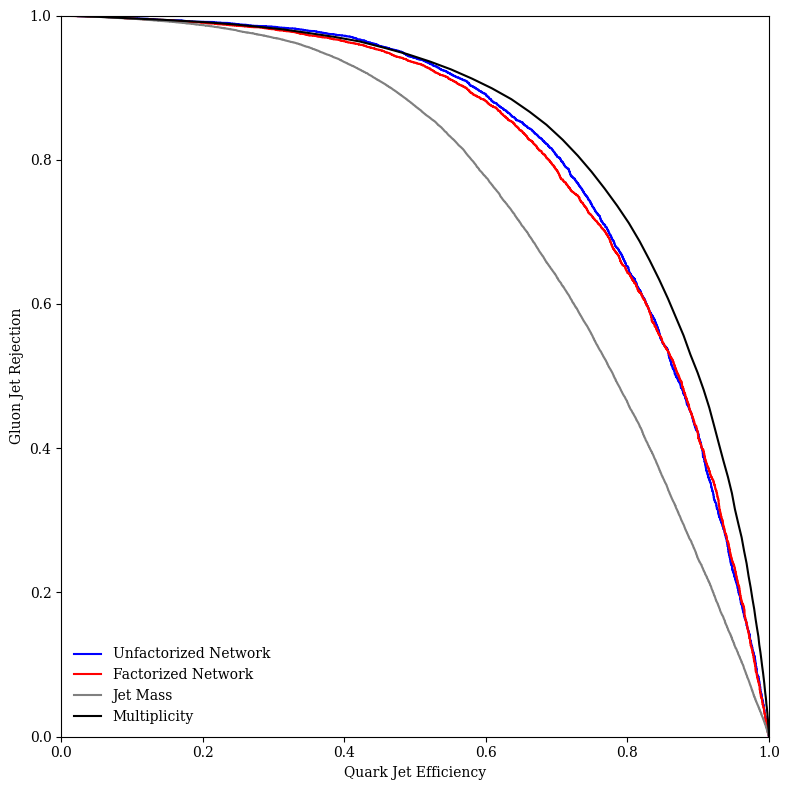

In [92]:
# some nicer plot settings 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 1, figsize=(8,8))

######################### ROC Curve Plot #########################
    # get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# plot the ROC curves
#our networks
axes.plot(efn_tp, 1-efn_fp, '-', color='blue', label='Unfactorized Network')
axes.plot(f_efn_tp, 1-f_efn_fp, '-', color='red', label='Factorized Network')
# mass/multiplicity
axes.plot(mass_tp, 1-mass_fp, '-', color='grey', label='Jet Mass')
axes.plot(mult_tp, 1-mult_fp, '-', color='black', label='Multiplicity')

# axes labels
axes.set_xlabel('Quark Jet Efficiency')
axes.set_ylabel('Gluon Jet Rejection')

# axes limits
axes.set_xlim(0, 1)
axes.set_ylim(0, 1)

# make legend and show plot
axes.legend(loc='lower left', frameon=False)
plt.show()